In [1]:
#Import the appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

#This can be removed after the first run
%pip install scipy


Note: you may need to restart the kernel to use updated packages.


Objective
The goal is to investigate whether or not there is a "home field advantage" for a nation that hosts the Olympic games. This analysis will study the Chinese olympic team, and try to determine if there was an unusually high improvement in performance during the 2008 Summer Olympic Games in Beijing.

Metrics to Produce
We will look at the following metrics in order to check for a host advantage, considering medal count as the measure for success in an Olympic Games:

Medal count trends:
Did the total medal count increase during the hosted olympics?
How many standard deviations (z-score) from the average medal count across all olympic games was the medal count for the hosted games?
Where did the host country place on the total medal rankings in their hosted games vs. other games?
How did the host country's performance metrics compare to the rest of the world's metrics? Does that tell us anything?

In [2]:
#read CSV file into a dataframe
olympics_path = "resources/athlete_events.csv"

olympics_df = pd.read_csv(olympics_path, low_memory = False)

#print the first 5 rows
olympics_df.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
# use only the Summer Olympics for Analysis
summer_df = olympics_df[olympics_df['Season'] == 'Summer']


In [4]:
#Create variables for the specific host country
host_country = 'Greece'
host_NOC = 'GRE'
host_year = 2004

# create a dataframe for only the host country, where the host value is anywhere in the team name
host_df = summer_df[summer_df['Team'].str.contains(host_country, case=False)]

# print the unique values of Team column to see if they are all related to the host country
print(host_df['Team'].unique())
print(host_df['NOC'].unique())

# Clean up the Team column to have ensure a single value for host
host_df.loc[:, 'Team'] = host_country
print(host_df['Team'].unique())

# It looks like NOC is a more accurate way to describe the country's team,
# and doesn't pose as many issues as the Team column does (e.g. "China-1", "China-2", etc.)
# Let's use NOC instead of Team for the rest of the analysis.

['Greece' 'Greece-3' 'Greece-1' 'Greece-2' 'Greece-4']
['GRE']
['Greece']


In [5]:
# create a dataframe where NOC is not related to the host country
rest_of_world_df = summer_df[summer_df['NOC'] != host_NOC]

# Clean up the team names to have only the country name
# if "-" appears in the team name, use only the part of the string that comes before "-"
rest_of_world_df.loc[:, 'Team'] = rest_of_world_df['Team'].str.split('-').str[0]

In [6]:
# create a dataframe that is the rest_of_world_df (referred to now as rw) grouped by Games, then NOC
# We can use this to calculate medal counts for each country in each Games
games_df_rw = rest_of_world_df.groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
# This will be, for each NOC, the sum of the medals won in each category for each games
games_df_rw['gold_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Gold'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['silver_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Silver'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['bronze_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Bronze'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']

# create a clean column for total medals
games_df_rw['total_medals'] = games_df_rw['Medal'] + games_df_rw['gold_medals'] + games_df_rw['silver_medals'] + games_df_rw['bronze_medals']
# fill NaN values with 0
games_df_rw = games_df_rw.fillna(0)

# format values in all columns except Games to integers
games_df_rw = games_df_rw.astype({'Medal': 'int', 'gold_medals': 'int', 'silver_medals': 'int', 'bronze_medals': 'int'})

games_df_rw

,Games,NOC,Medal,gold_medals,silver_medals,bronze_medals,total_medals
0,1896 Summer,AUS,3,2,1,1,7.0
1,1896 Summer,AUT,5,2,2,2,11.0
2,1896 Summer,DEN,6,1,4,3,14.0
3,1896 Summer,FRA,11,5,3,2,21.0
4,1896 Summer,GBR,9,3,5,3,20.0
...,...,...,...,...,...,...,...
2776,2016 Summer,VIE,2,0,0,0,0.0
2777,2016 Summer,VIN,0,0,0,0,0.0
2778,2016 Summer,YEM,0,0,0,0,0.0
2779,2016 Summer,ZAM,0,0,0,0,0.0


In [7]:
# create a dataframe for the host country in the Summer Olympics grouped by Games.
games_df_host = host_df.groupby('Games').agg({'Medal': 'count'})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_host['gold_medals'] = host_df[host_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_host['silver_medals'] = host_df[host_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_host['bronze_medals'] = host_df[host_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# fill NaN values with 0
games_df_host = games_df_host.fillna(0)

# format values in all columns except Games to integers
games_df_host = games_df_host.astype(int)

games_df_host

,Medal,gold_medals,silver_medals,bronze_medals
Games,,,,
1896 Summer,46,10,18,18
1900 Summer,0,0,0,0
1904 Summer,2,1,0,1
1906 Summer,34,7,15,12
1908 Summer,4,0,3,1
1912 Summer,2,1,0,1
1920 Summer,5,0,5,0
1924 Summer,1,1,0,0
1928 Summer,0,0,0,0


In [8]:
# create a cleaner "total_medals" column
games_df_host['total_medals'] = games_df_host[['gold_medals', 'silver_medals', 'bronze_medals']].sum(axis=1)

# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_host['non_medal_participations'] = host_df[host_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_host['total_participations'] = host_df.groupby('Games').size()
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations
Games,,,,,,,
1896 Summer,46,10,18,18,46,100,146
1900 Summer,0,0,0,0,0,4,4
1904 Summer,2,1,0,1,2,10,12
1906 Summer,34,7,15,12,34,298,332
1908 Summer,4,0,3,1,4,45,49
1912 Summer,2,1,0,1,2,75,77
1920 Summer,5,0,5,0,5,93,98
1924 Summer,1,1,0,0,1,78,79
1928 Summer,0,0,0,0,0,47,47


In [9]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_host['medal_rate'] = games_df_host['total_medals'] / games_df_host['total_participations']
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate
Games,,,,,,,,
1896 Summer,46,10,18,18,46,100,146,0.315068
1900 Summer,0,0,0,0,0,4,4,0.000000
1904 Summer,2,1,0,1,2,10,12,0.166667
1906 Summer,34,7,15,12,34,298,332,0.102410
1908 Summer,4,0,3,1,4,45,49,0.081633
1912 Summer,2,1,0,1,2,75,77,0.025974
1920 Summer,5,0,5,0,5,93,98,0.051020
1924 Summer,1,1,0,0,1,78,79,0.012658
1928 Summer,0,0,0,0,0,47,47,0.000000


In [10]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_host['gold_percentage'] = games_df_host['gold_medals'] / games_df_host['total_medals']
games_df_host['silver_percentage'] = games_df_host['silver_medals'] / games_df_host['total_medals']
games_df_host['bronze_percentage'] = games_df_host['bronze_medals'] / games_df_host['total_medals']
games_df_host['non_medal_percentage'] = games_df_host['non_medal_participations'] / games_df_host['total_participations']

games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1896 Summer,46,10,18,18,46,100,146,0.315068,0.217391,0.391304,0.391304,0.684932
1900 Summer,0,0,0,0,0,4,4,0.000000,NaN,NaN,NaN,1.000000
1904 Summer,2,1,0,1,2,10,12,0.166667,0.500000,0.000000,0.500000,0.833333
1906 Summer,34,7,15,12,34,298,332,0.102410,0.205882,0.441176,0.352941,0.897590
1908 Summer,4,0,3,1,4,45,49,0.081633,0.000000,0.750000,0.250000,0.918367
1912 Summer,2,1,0,1,2,75,77,0.025974,0.500000,0.000000,0.500000,0.974026
1920 Summer,5,0,5,0,5,93,98,0.051020,0.000000,1.000000,0.000000,0.948980
1924 Summer,1,1,0,0,1,78,79,0.012658,1.000000,0.000000,0.000000,0.987342
1928 Summer,0,0,0,0,0,47,47,0.000000,NaN,NaN,NaN,1.000000


<Axes: title={'center': 'Medals Won by INSERT HOST NAME in the Summer Olympics'}, xlabel='Games'>

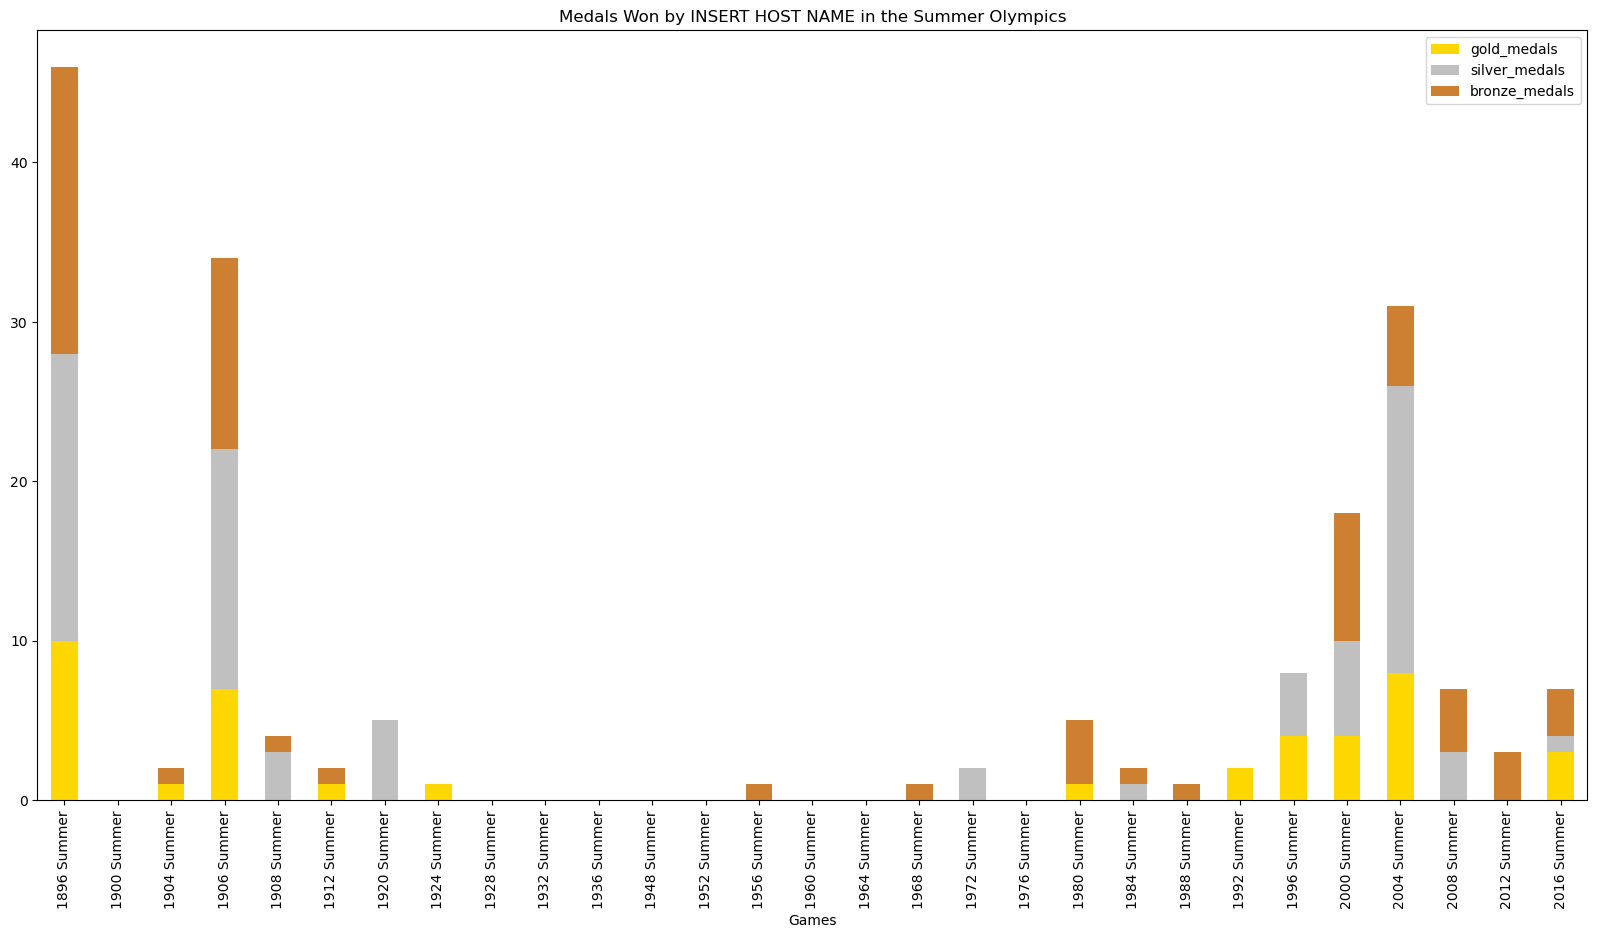

In [11]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the host country in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations

games_df_host[['gold_medals', 'silver_medals', 'bronze_medals']].plot(
                                    kind='bar',
                                    stacked=True,
                                    figsize=(20, 10),
                                    color=['#ffd700', '#c0c0c0', '#cd7f32'],
                                    title='Medals Won by INSERT HOST NAME in the Summer Olympics',)
# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze

<Axes: title={'center': 'Medal Rate for [INSERT HOST COUNTRY] in the Summer Olympics'}, xlabel='Games'>

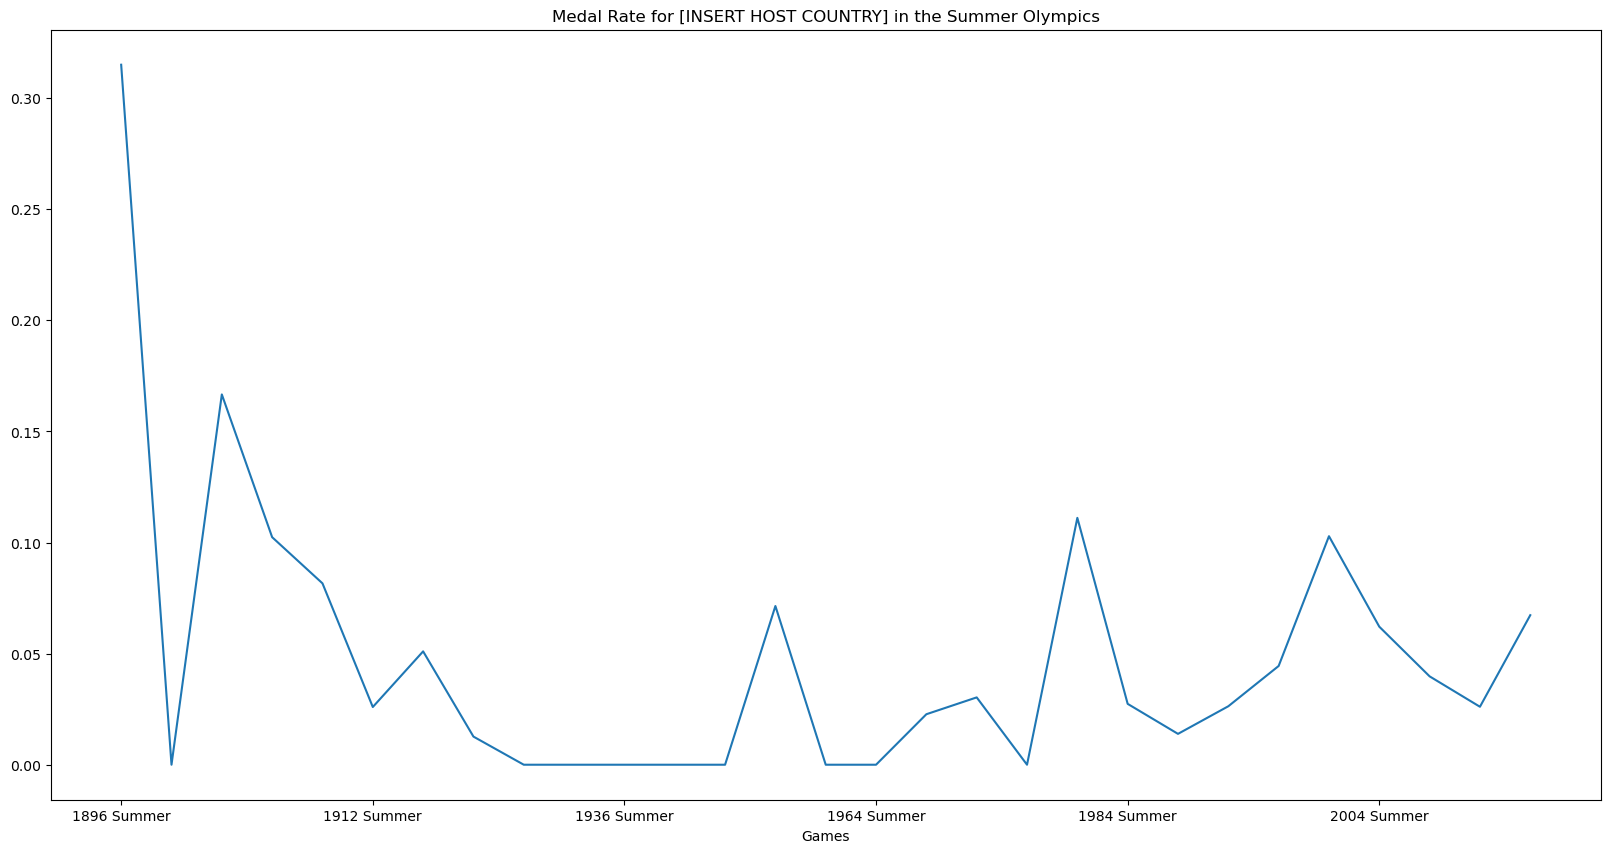

In [12]:
# Use a line chart to plot the medal_rate for the host country in the Summer Olympics.
games_df_host['medal_rate'].plot(kind='line', figsize=(20, 10), title='Medal Rate for [INSERT HOST COUNTRY] in the Summer Olympics')

<Axes: xlabel='Games'>

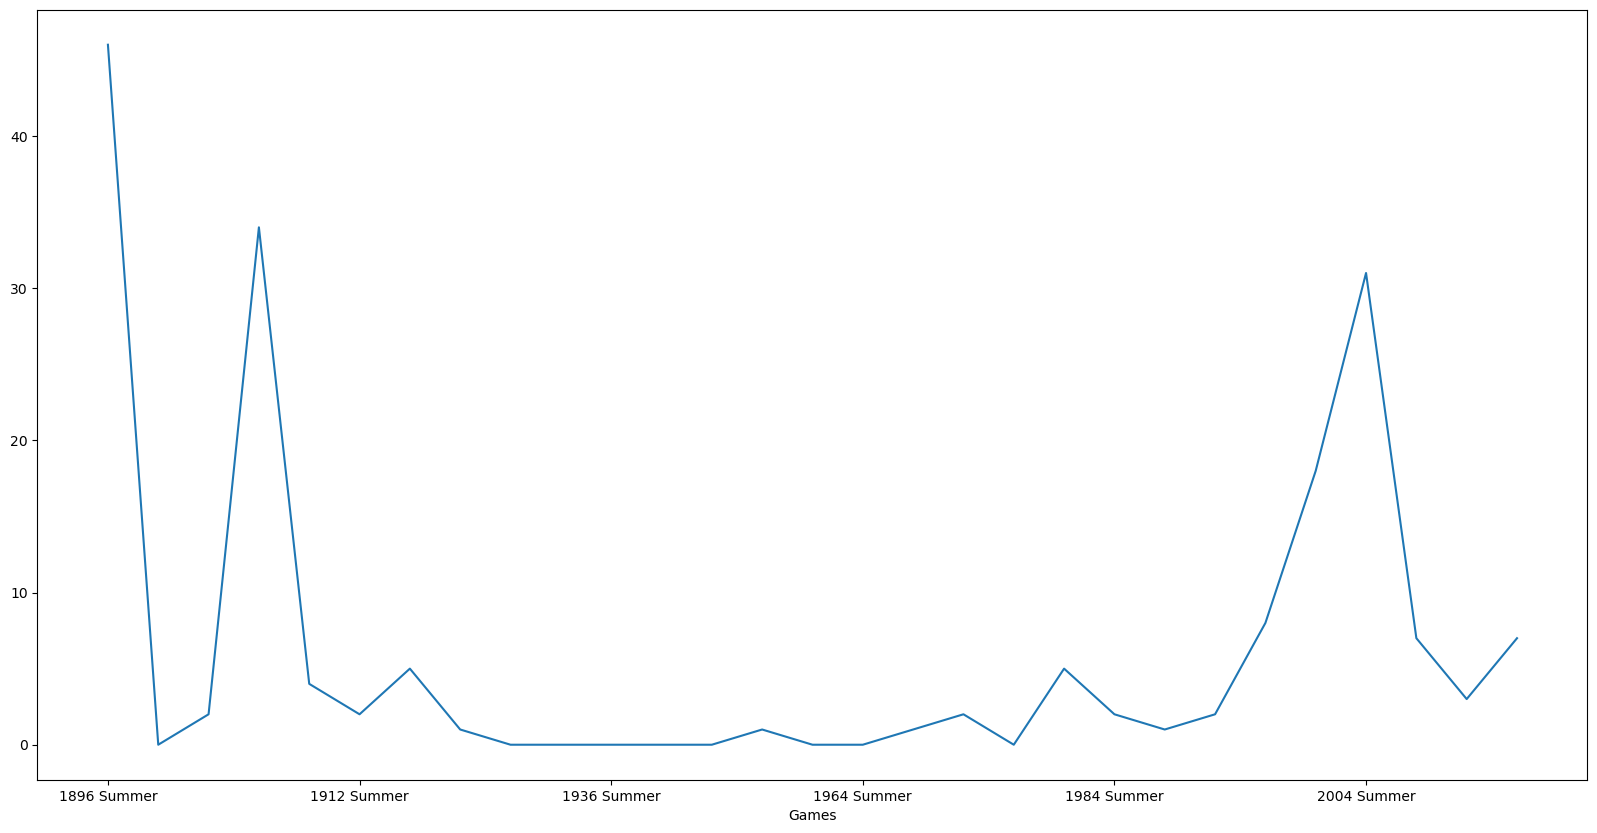

In [13]:
# Use a line chart to plot the medal count for the host country in the Summer Olympics.
games_df_host['total_medals'].plot(kind='line', figsize=(20, 10))

In [14]:
# Calculate the average medal count for the English team for the summer olympics
average_medal_count_host = games_df_host['total_medals'].mean()
print(average_medal_count_host)

# Calculate the average medal count for the Chinese team in the games where they won at least one medal
average_medal_count_host_won = games_df_host[games_df_host['total_medals'] > 0]['total_medals'].mean()
print(average_medal_count_host_won)

6.275862068965517
9.1


In [15]:
# Show the medal count for the host year Summer Games
games_df_host.loc[f'{host_year} Summer']



Medal                        31.000000
gold_medals                   8.000000
silver_medals                18.000000
bronze_medals                 5.000000
total_medals                 31.000000
non_medal_participations    468.000000
total_participations        499.000000
medal_rate                    0.062124
gold_percentage               0.258065
silver_percentage             0.580645
bronze_percentage             0.161290
non_medal_percentage          0.937876
Name: 2004 Summer, dtype: float64

In [16]:
# add z_scores column to the games_df_host dataframe
games_df_host['z_scores'] = zscore(games_df_host['total_medals'])
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage,z_scores
Games,,,,,,,,,,,,,
1896 Summer,46,10,18,18,46,100,146,0.315068,0.217391,0.391304,0.391304,0.684932,3.528401
1900 Summer,0,0,0,0,0,4,4,0.000000,NaN,NaN,NaN,1.000000,-0.557438
1904 Summer,2,1,0,1,2,10,12,0.166667,0.500000,0.000000,0.500000,0.833333,-0.379793
1906 Summer,34,7,15,12,34,298,332,0.102410,0.205882,0.441176,0.352941,0.897590,2.462530
1908 Summer,4,0,3,1,4,45,49,0.081633,0.000000,0.750000,0.250000,0.918367,-0.202148
1912 Summer,2,1,0,1,2,75,77,0.025974,0.500000,0.000000,0.500000,0.974026,-0.379793
1920 Summer,5,0,5,0,5,93,98,0.051020,0.000000,1.000000,0.000000,0.948980,-0.113325
1924 Summer,1,1,0,0,1,78,79,0.012658,1.000000,0.000000,0.000000,0.987342,-0.468616
1928 Summer,0,0,0,0,0,47,47,0.000000,NaN,NaN,NaN,1.000000,-0.557438


c:\Users\brand\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_medals', ylabel='Count'>

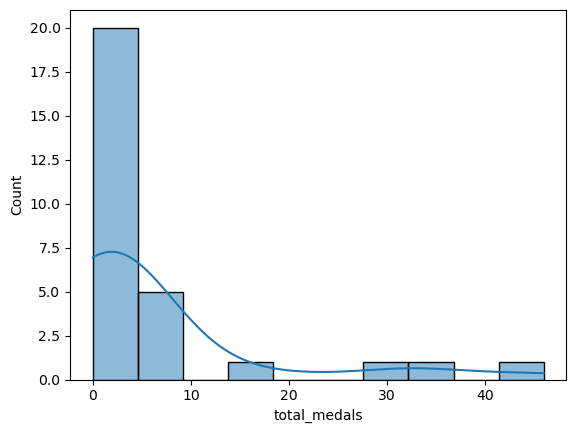

In [17]:
# Plot the distribution of the medal count for the host country in the Summer Olympics
sns.histplot(games_df_host['total_medals'], bins=10, kde=True)

In [18]:
mean_total_medals_host = games_df_host[games_df_host.index != f'{host_year} Summer']['total_medals'].mean()
print(mean_total_medals_host)

z_score_total_medals_gb = zscore(games_df_host[games_df_host.index != f'{host_year} Summer']['total_medals'])
print(z_score_total_medals_gb)

5.392857142857143
Games
1896 Summer    3.895412
1900 Summer   -0.517333
1904 Summer   -0.325474
1906 Summer    2.744261
1908 Summer   -0.133616
1912 Summer   -0.325474
1920 Summer   -0.037686
1924 Summer   -0.421403
1928 Summer   -0.517333
1932 Summer   -0.517333
1936 Summer   -0.517333
1948 Summer   -0.517333
1952 Summer   -0.517333
1956 Summer   -0.421403
1960 Summer   -0.517333
1964 Summer   -0.517333
1968 Summer   -0.421403
1972 Summer   -0.325474
1976 Summer   -0.517333
1980 Summer   -0.037686
1984 Summer   -0.325474
1988 Summer   -0.421403
1992 Summer   -0.325474
1996 Summer    0.250101
2000 Summer    1.209394
2008 Summer    0.154172
2012 Summer   -0.229545
2016 Summer    0.154172
Name: total_medals, dtype: float64


In [19]:
# Using our games_df_rw dataframe, let's get the Summer Games data
summer_host_yr_rw = games_df_rw[games_df_rw['Games'] == f'{host_year} Summer']

# let's order this data by descending medal count
summer_host_yr_rw = summer_host_yr_rw.sort_values(by='Medal', ascending=False)

# let's only use the Games, NOC, and Medal columns
summer_host_yr_rw_short = summer_host_yr_rw[['Games', 'NOC', 'Medal']]
print('[INSERT HOST COUNTRY] 2012 Medal Count for the Rest of the World:')
summer_host_yr_rw_short.head()

[INSERT HOST COUNTRY] 2012 Medal Count for the Rest of the World:


,Games,NOC,Medal
2159,2004 Summer,USA,263
2122,2004 Summer,RUS,189
1979,2004 Summer,AUS,157
2040,2004 Summer,GER,149
2059,2004 Summer,ITA,104


In [20]:
# Let's calculate the average medal count for the rest of the world in the Summer Olympics
average_medal_count_rw_host_yr = summer_host_yr_rw['Medal'].mean()
average_medal_count_rw_host_yr

9.85